## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [1]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [2]:
url ='data/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [3]:
df.shape

(2218, 18)

In [4]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [5]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [6]:
# looked at the value_counts for deceased 
#date to see what year this was based in
df['deceased_date'].value_counts()

2020-02-23    4
2020-03-04    3
2020-03-02    3
2020-03-01    3
2020-03-09    3
2020-03-05    3
2020-02-25    2
2020-03-07    2
2020-03-19    2
2020-02-27    1
2020-02-26    1
2020-03-03    1
2020-02-24    1
2020-02-21    1
2020-02-19    1
2020-03-06    1
Name: deceased_date, dtype: int64

In [7]:
#explore birth year to see the format of the numbers
df['birth_year']

0       1964.0
1       1987.0
2       1964.0
3       1991.0
4       1992.0
         ...  
2213    1990.0
2214    1998.0
2215    1998.0
2216    1972.0
2217    1974.0
Name: birth_year, Length: 2218, dtype: float64

In [8]:
# creating the new column
df['n_age']=2020.0-df['birth_year']

In [9]:
# double check that the calculations came out right. 
df['n_age'].head()

0    56.0
1    33.0
2    56.0
3    29.0
4    28.0
Name: n_age, dtype: float64

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [10]:
df.isnull().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [12]:
# see the unique values
df['disease'].unique()

array([nan, True], dtype=object)

In [13]:
# filling the null values wiht 0
df['disease'].fillna(0,inplace=True)

In [14]:
# converting True to 1 
df['disease']= df['disease'].astype(int)

In [15]:
# checking the that the conversion worked
df['disease'].unique()

array([0, 1])

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [16]:
df['global_num'].fillna(int(df['global_num'].mean()),inplace=True)

In [17]:
df['birth_year'].fillna(int(df['birth_year'].mean()),inplace=True)

In [18]:
df['infection_order'].fillna(int(df['infection_order'].mean()),inplace=True)

In [19]:
df['infected_by'].fillna(int(df['infected_by'].mean()),inplace=True)

In [20]:
df['contact_number'].fillna(int(df['contact_number'].mean()),inplace=True)

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [21]:
#checking unique values for infection case
df['infection_case'].unique()

array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Pilgrimage to Israel'], dtype=object)

In [22]:
# filling missing values with etc to match what was in unique values
df['infection_case'].fillna("etc", inplace=True)

In [23]:
df['city'].unique()

array(['Gangseo-gu', 'Jungnang-gu', 'Jongno-gu', 'Mapo-gu', 'Seongbuk-gu',
       'etc', 'Songpa-gu', 'Seodaemun-gu', 'Seongdong-gu', 'Seocho-gu',
       'Guro-gu', 'Gangdong-gu', 'Eunpyeong-gu', 'Geumcheon-gu',
       'Gwanak-gu', 'Nowon-gu', 'Dongjak-gu', 'Gangnam-gu',
       'Yangcheon-gu', 'Gwangjin-gu', 'Dongdaemun-gu', 'Yeongdeungpo-gu',
       'Dobong-gu', 'Yongsan-gu', 'Gangbuk-gu', 'Jung-gu', 'Dongnae-gu',
       'Haeundae-gu', 'Yeonje-gu', nan, 'Buk-gu', 'Nam-gu', 'Seo-gu',
       'Geumjeong-gu', 'Saha-gu', 'Suyeong-gu', 'Sasang-gu',
       'Busanjin-gu', 'Dalseo-gu', 'Dalseong-gun', 'Suseong-gu',
       'Dong-gu', 'Wuhan', 'Bupyeong-gu', 'Michuhol-gu', 'Yeonsu-gu',
       'Gyeyang-gu', 'Namdong-gu', 'Yuseong-gu', 'Daedeok-gu', 'Ulju-gun',
       'Sejong', 'Goyang-si', 'Pyeongtaek-si', 'Bucheon-si', 'Suwon-si',
       'Guri-si', 'Siheung-si', 'Gimpo-si', 'Icheon-si', 'Pocheon-si',
       'Anyang-si', 'Yongin-si', 'Paju-si', 'Namyangju-si', 'Seongnam-si',
       'Gwangmyeong-s

In [24]:
#will fill city with the province.  
df['city'].fillna(df['province'], inplace=True)

In [25]:
df['state'].unique()

array(['released', 'isolated', 'deceased', nan], dtype=object)

In [26]:
df[df['state'].isnull()]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
802,2000000214,8168.0,female,1967.0,NaN,Korea,Gyeonggi-do,Seongnam-si,0,contact with patient,2.0,2.000000e+09,2.0,NaN,2020-03-15,NaN,NaN,NaN,53.0
803,2000000215,8195.0,female,1974.0,NaN,Korea,Gyeonggi-do,Bucheon-si,0,contact with patient,2.0,2.000000e+09,24.0,NaN,2020-03-15,NaN,NaN,NaN,46.0
804,2000000216,8212.0,female,1963.0,NaN,Korea,Gyeonggi-do,Seongnam-si,0,etc,2.0,2.600789e+09,11.0,2020-03-13,2020-03-15,NaN,NaN,NaN,57.0
805,2000000217,8205.0,female,1954.0,NaN,Korea,Gyeonggi-do,Seongnam-si,0,contact with patient,2.0,2.000000e+09,24.0,NaN,2020-03-15,NaN,NaN,NaN,66.0
806,2000000218,8184.0,female,1992.0,NaN,Korea,Gyeonggi-do,Seongnam-si,0,contact with patient,2.0,2.000000e+09,24.0,NaN,2020-03-15,NaN,NaN,NaN,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,2000000297,8473.0,female,1969.0,NaN,Korea,Gyeonggi-do,Seongnam-si,0,contact with patient,2.0,2.600789e+09,24.0,NaN,2020-03-18,NaN,NaN,NaN,51.0
886,2000000298,8503.0,female,1969.0,NaN,Korea,Gyeonggi-do,Namyangju-si,0,contact with patient,2.0,2.000000e+09,24.0,NaN,2020-03-18,NaN,NaN,NaN,51.0
887,2000000299,4664.0,female,1985.0,NaN,Korea,Gyeonggi-do,Namyangju-si,0,overseas inflow,2.0,2.600789e+09,24.0,NaN,2020-03-18,NaN,NaN,NaN,35.0
888,2000000300,4664.0,male,1989.0,NaN,Korea,Gyeonggi-do,Seongnam-si,0,overseas inflow,2.0,2.600789e+09,24.0,NaN,2020-03-18,NaN,NaN,NaN,31.0


In [27]:
df['state'].value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

In [28]:
#not sure if assume isolated and still sick or if we should classify as unknown 
df['state'].fillna("unknown", inplace=True)

In [29]:
df['n_age'].fillna((2020.0-df['birth_year']),inplace=True)

In [30]:
# since we already have n_age I will delete the age 
df=df.drop(['age'],axis=1)

In [31]:
df['sex'].value_counts()

female    1171
male       902
Name: sex, dtype: int64

In [32]:
145/2217

0.06540369869192603

In [33]:
#drop the rows with null values since it's low. 
df=df.dropna(axis=0, subset=['sex'])

In [34]:
df.isnull().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    1880
confirmed_date           1
released_date         1851
deceased_date         2041
state                    0
n_age                    0
dtype: int64

 **<font color='teal'> Check for any remaining null values.</font>**

In [35]:
df.isnull().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    1880
confirmed_date           1
released_date         1851
deceased_date         2041
state                    0
n_age                    0
dtype: int64

In [36]:
df.head()

,patient_id,global_num,sex,birth_year,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0
1,1000000002,5.0,male,1987.0,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,33.0
2,1000000003,6.0,male,1964.0,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,56.0
3,1000000004,7.0,male,1991.0,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0
4,1000000005,9.0,female,1992.0,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,28.0


Remove date columns from the data.


In [37]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [38]:
print(df.nunique())

patient_id         2073
global_num         1303
sex                   2
birth_year           96
country               4
province             17
city                133
disease               2
infection_case       16
infection_order       6
infected_by         207
contact_number       72
state                 4
n_age                96
dtype: int64


In [45]:
#drop patient id due to high variablity
df=df.drop(['patient_id'], axis=1)

Review the percent of unique values by column.

In [46]:
print(df.nunique()/df.shape[0])

global_num         0.628558
sex                0.000965
birth_year         0.046310
country            0.001930
province           0.008201
city               0.064158
disease            0.000965
infection_case     0.007718
infection_order    0.002894
infected_by        0.099855
contact_number     0.034732
state              0.001930
n_age              0.046310
dtype: float64


Review the range of values per column.

In [40]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2073.0,3.876378e+09,2.201365e+09,1.000000e+09,1.600000e+09,4.100000e+09,6.001000e+09,7.000000e+09
global_num,2073.0,4.664518e+03,2.287868e+03,1.000000e+00,3.946000e+03,4.664000e+03,6.151000e+03,8.717000e+03
birth_year,2073.0,1.974841e+03,1.791018e+01,1.916000e+03,1.964000e+03,1.974000e+03,1.990000e+03,2.020000e+03
disease,2073.0,9.165461e-03,9.531966e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2073.0,2.005789e+00,1.810663e-01,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00
infected_by,2073.0,2.600789e+09,7.464560e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2073.0,2.402894e+01,4.051860e+01,0.000000e+00,2.400000e+01,2.400000e+01,2.400000e+01,1.160000e+03
n_age,2073.0,4.515871e+01,1.791018e+01,0.000000e+00,3.000000e+01,4.600000e+01,5.600000e+01,1.040000e+02


### Check for duplicated rows

In [41]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [42]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,country,4
2,province,17
3,city,133
4,infection_case,16
5,state,4


**<font color='teal'> Plot the correlation heat map for the features.</font>**

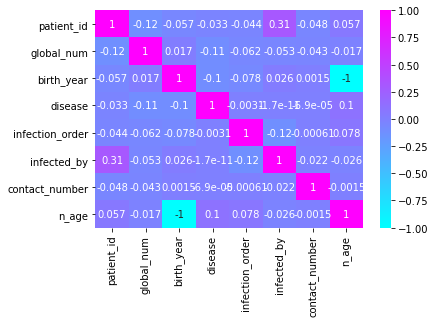

In [43]:
dataplot=sns.heatmap(df.corr(),cmap='cool', annot=True)

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

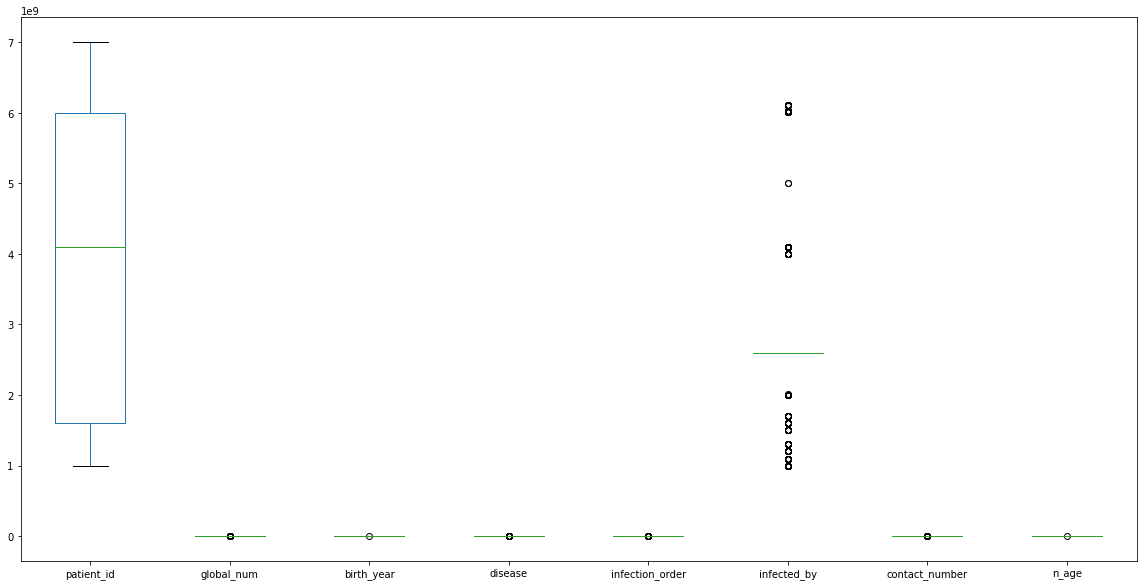

In [44]:
df.plot(kind='box', figsize=(20,10))
plt.show()

**<font color='teal'> Create dummy features for object type features. </font>**

changing state from words to numbers 

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2217
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   global_num       2073 non-null   float64
 1   sex              2073 non-null   object 
 2   birth_year       2073 non-null   float64
 3   country          2073 non-null   object 
 4   province         2073 non-null   object 
 5   city             2073 non-null   object 
 6   disease          2073 non-null   int64  
 7   infection_case   2073 non-null   object 
 8   infection_order  2073 non-null   float64
 9   infected_by      2073 non-null   float64
 10  contact_number   2073 non-null   float64
 11  state            2073 non-null   object 
 12  n_age            2073 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 226.7+ KB


In [50]:
df['state'].value_counts()

isolated    1648
released     306
unknown       88
deceased      31
Name: state, dtype: int64

In [57]:
df=pd.get_dummies(df, 
                  columns=[
                      'sex','country','province',
                      'city','infection_case'])

### Split the data into test and train subsamples

In [58]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X=df.drop(['state'], axis=1, inplace=False)
y= df['state']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [59]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [60]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [61]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.853
Random Forest: f1-score=0.828


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [62]:
class_names=['isolated','released','unknown','deceased'] # name  of classes

Confusion matrix, without normalization
[[  5   0   0   0]
 [  1 316  10   0]
 [  0  49  18   0]
 [  0   1   0  15]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.97 0.03 0.  ]
 [0.   0.73 0.27 0.  ]
 [0.   0.06 0.   0.94]]


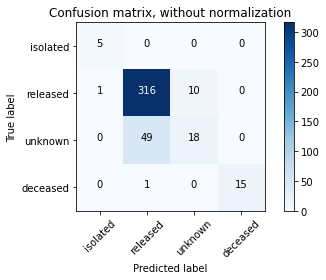

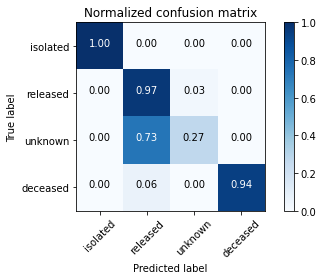

In [63]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


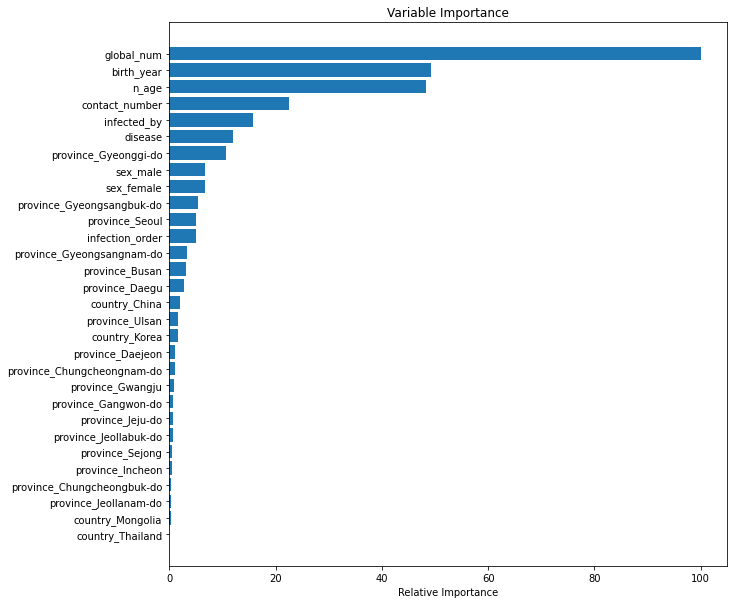

In [64]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.